<a href="https://colab.research.google.com/github/iakovkh/mypython/blob/main/LSTM_example32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0/1000, Loss: 0.903153121471405
Epoch 50/1000, Loss: 0.4540313184261322
Epoch 100/1000, Loss: 0.2786312699317932
Epoch 150/1000, Loss: 0.19882133603096008
Epoch 200/1000, Loss: 0.16672243177890778
Epoch 250/1000, Loss: 0.15495333075523376
Epoch 300/1000, Loss: 0.1499732881784439
Epoch 350/1000, Loss: 0.14718951284885406
Epoch 400/1000, Loss: 0.121133953332901
Epoch 450/1000, Loss: 0.1118176057934761
Epoch 500/1000, Loss: 0.10441399365663528
Epoch 550/1000, Loss: 0.09786136448383331
Epoch 600/1000, Loss: 0.09262943267822266
Epoch 650/1000, Loss: 0.08763329684734344
Epoch 700/1000, Loss: 0.0834202766418457
Epoch 750/1000, Loss: 0.0800025537610054
Epoch 800/1000, Loss: 0.07667721062898636
Epoch 850/1000, Loss: 0.07304229587316513
Epoch 900/1000, Loss: 0.06920555979013443
Epoch 950/1000, Loss: 0.06632713228464127


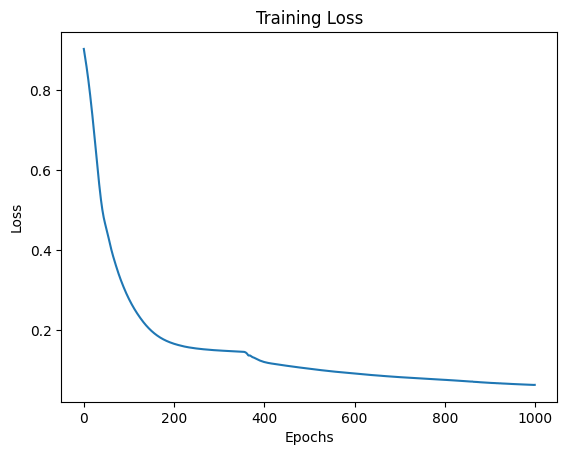

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Configuration section
data_file_name = '/content/sample_data/NN_cut2.xlsx'
validate_file_name = '/content/sample_data/NN_control_02.xlsx'
normalize_data = True
train_ratio = 0.8
optimizer_name = 'Adam'  # Other options: 'SGD', 'RMSprop', 'Adagrad', etc.
loss_function_name = 'MSELoss'  # Other options: 'L1Loss', 'CrossEntropyLoss', etc.
activation_function_name = 'ReLU'  # Other options: 'Sigmoid', 'Tanh', etc.
epochs = 1000
network_structure = [(1, 32), (2, 9), (3, 3), (4, 2)]
display_network_structure = False

# Step I - General data preparation
class MyMatrix:
    def __init__(self):
        self.data = None

    def read_data_from_file(self, file_name):
        self.data = pd.read_excel(file_name)

    def normalize_data(self):
        scaler = MinMaxScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)

    def display_console(self, column=None):
        if column:
            print(self.data[column])
        else:
            print(self.data)

    def display_visual(self, column=None):
        if column:
            self.data[column].plot()
            plt.show()
        else:
            self.data.plot(subplots=True)
            plt.show()

# Step II – Read and prepare data
MyData = MyMatrix()
MyData.read_data_from_file(data_file_name)

if normalize_data:
    MyData.normalize_data()

train_size = int(len(MyData.data) * train_ratio)
train_data = MyData.data.iloc[:train_size]
test_data = MyData.data.iloc[train_size:]

# Step III – Design the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, network_structure, activation_function):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i, (layer_num, neurons) in enumerate(network_structure):
            if i == 0:
                layers.append(nn.Linear(input_size, neurons))
            else:
                layers.append(nn.Linear(network_structure[i-1][1], neurons))
            if i < len(network_structure) - 1:
                layers.append(activation_function())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_size = train_data.shape[1] - 2
activation_function = getattr(nn, activation_function_name)
model = NeuralNetwork(input_size, network_structure, activation_function)

if display_network_structure:
    print("Network Structure:")
    for i, (layer_num, neurons) in enumerate(network_structure):
        print(f"Layer {layer_num}: {neurons} neurons")
    print("Training Data:")
    print(train_data)
    print("Testing Data:")
    print(test_data)

# Training the network
optimizer = getattr(optim, optimizer_name)(model.parameters())
loss_function = getattr(nn, loss_function_name)()

train_inputs = torch.tensor(train_data.iloc[:, 2:].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data.iloc[:, :2].values, dtype=torch.float32)
test_inputs = torch.tensor(test_data.iloc[:, 2:].values, dtype=torch.float32)
test_outputs = torch.tensor(test_data.iloc[:, :2].values, dtype=torch.float32)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = loss_function(outputs, train_outputs)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step IV - Forecasting results
MyData.read_data_from_file(validate_file_name)
if normalize_data:
    MyData.normalize_data()

validate_inputs = torch.tensor(MyData.data.iloc[:, 2:].values, dtype=torch.float32)
predictions = model(validate_inputs).detach().numpy()

output_df = pd.DataFrame(predictions, columns=['Predicted_Column1', 'Predicted_Column2'])
output_df.to_excel('output.xlsx', index=False)
